In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from alphavantage_api.AlphaVantageCommodities import AlphaVantageCommodities
from tools.PandasDataFrameNormalizer import PandasDataFrameNormalizer
from dotenv import load_dotenv
import seaborn as sns

load_dotenv()

2023-11-17 18:10:46.966055: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-17 18:10:46.966141: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-17 18:10:46.966162: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-17 18:10:46.971929: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


True

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


2023-11-17 18:11:42.122590: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-17 18:11:42.128075: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-17 18:11:42.128408: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


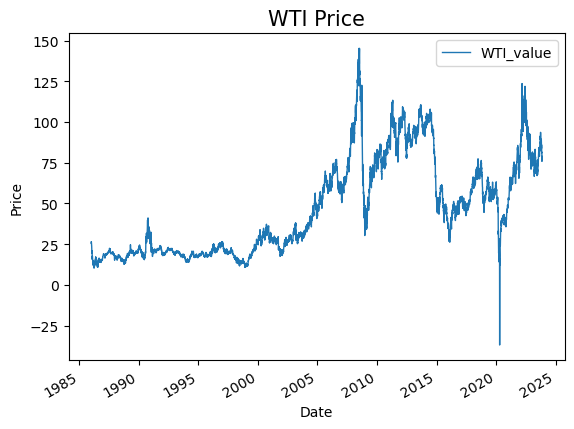

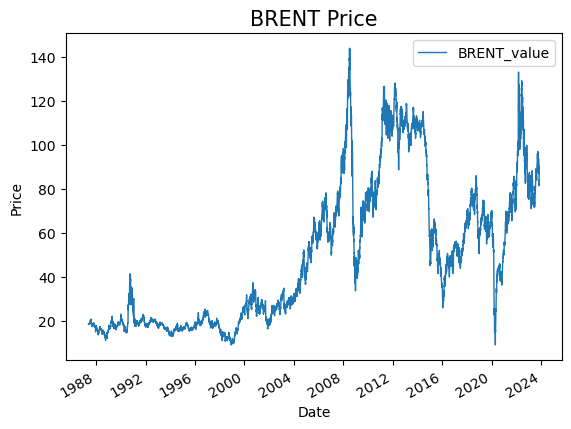

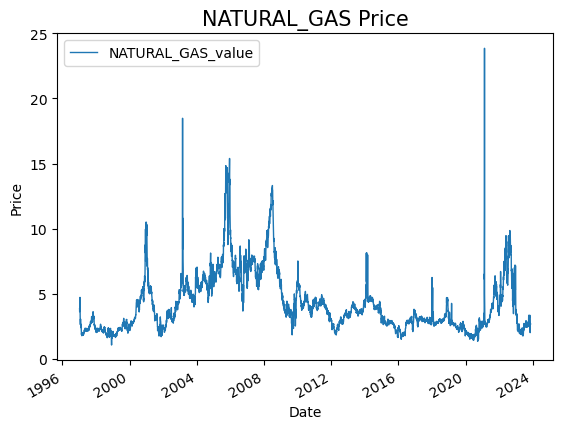

In [3]:
avc = AlphaVantageCommodities()
for symbol in avc.get_all_curated_series_ids():
    avc.plot_series_id(symbol)

In [4]:
df_merged = avc.get_data_as_pandas_df_multiple_series_ids(['WTI','BRENT','NATURAL_GAS'])

In [5]:
df_merged = df_merged.dropna()

<Axes: xlabel='date'>

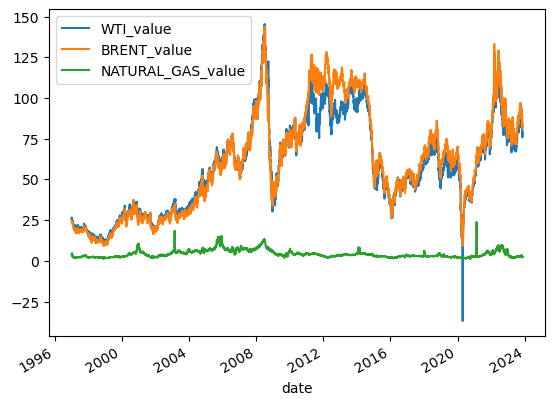

In [6]:
df_merged.plot(x="date")

<Axes: >

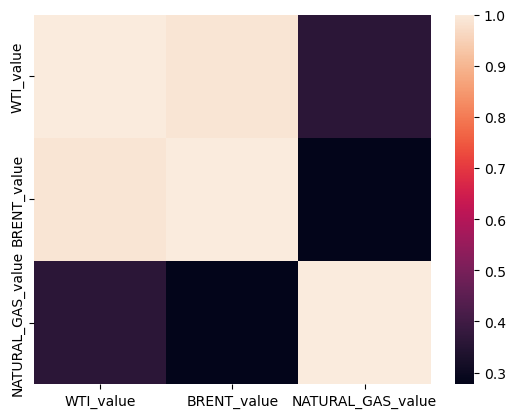

In [7]:
df_corr = df_merged.corr(numeric_only=True)
sns.heatmap(df_corr)

In [8]:
# Normalize data
normalizer_wti = PandasDataFrameNormalizer()
df_normalized = normalizer_wti.normalize_pandas_data_frame_column(df_merged,'WTI_value')

normalizer_brent = PandasDataFrameNormalizer()
df_normalized = normalizer_brent.normalize_pandas_data_frame_column(df_merged,'BRENT_value')

normalizer_natural_gas = PandasDataFrameNormalizer()
df_normalized = normalizer_natural_gas.normalize_pandas_data_frame_column(df_merged,'NATURAL_GAS_value')

In [9]:
df_normalized.tail()

,date,WTI_value,BRENT_value,NATURAL_GAS_value
9534,2023-11-06,0.650173,0.579978,0.072775
9535,2023-11-07,0.630534,0.551205,0.041648
9536,2023-11-08,0.618959,0.536596,0.049540
9537,2023-11-09,0.621647,0.538673,0.072775
9538,2023-11-13,0.635471,0.556099,0.068391


<Axes: xlabel='date'>

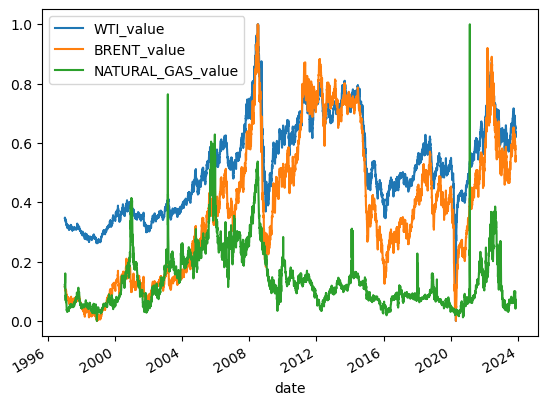

In [10]:
df_normalized.plot(x="date")

In [11]:
data = df_normalized[['WTI_value','BRENT_value','NATURAL_GAS_value']].to_numpy()
data

array([[0.3468649 , 0.11612904, 0.12143796],
       [0.34851062, 0.11627735, 0.12056115],
       [0.34713918, 0.11664813, 0.11223147],
       ...,
       [0.61895883, 0.53659624, 0.04953968],
       [0.6216468 , 0.5386726 , 0.0727751 ],
       [0.6354709 , 0.5560994 , 0.06839105]], dtype=float32)

In [12]:
data.size

19983

In [13]:
np.shape(data)

(6661, 3)

In [14]:
print('Data lenght: ' + str(len(data)))

Data lenght: 6661


In [15]:
left_size = 0.8
split_at = int(left_size * len(data))
print('Split at: ' + str(split_at))

Split at: 5328


In [16]:
forecasting_label_steps = 10
feature_sequence_length = 100

x_train = data[0:split_at]
x_train_data = x_train[:-(feature_sequence_length+forecasting_label_steps)]
x_train_targets = x_train[feature_sequence_length+forecasting_label_steps:, 0]

x_test = data[split_at+1:]
x_test_data = x_test[:-(feature_sequence_length+forecasting_label_steps)]
x_test_targets = x_test[feature_sequence_length+forecasting_label_steps:, 0]

In [17]:
len(x_train_data)

5218

In [18]:
len(x_train_targets)

5218

In [19]:
len(x_test_data)

1222

In [20]:
x_train_data[100:,0]

array([0.3142246 , 0.3114817 , 0.3070931 , ..., 0.53113174, 0.5345329 ,
       0.5340392 ], dtype=float32)

In [21]:
x_train_targets

array([0.3065445 , 0.30572167, 0.3048988 , ..., 0.5670086 , 0.56838006,
       0.56991607], dtype=float32)

In [22]:
dataset_train = tf.keras.utils.timeseries_dataset_from_array(x_train_data, x_train_targets, sequence_length=feature_sequence_length, sampling_rate=1, batch_size=32)

2023-11-16 20:39:29.858636: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-16 20:39:29.859379: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-16 20:39:29.860077: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-16 20:39:30.810987: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-16 20:39:30.811376: I tensorflow/compile

In [23]:
#for inputs, targets in dataset_train:
#  print("Input:", inputs.numpy(), "Target:", targets.numpy())

In [24]:
dataset_test = tf.keras.utils.timeseries_dataset_from_array(x_test_data, x_test_targets, sequence_length=feature_sequence_length, sampling_rate=1, batch_size=32)

In [25]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    
print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (32, 100, 3)
Target shape: (32,)


In [26]:
layer_inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
layer_lstm_1 = keras.layers.LSTM(64, return_sequences=True, recurrent_dropout=0.1)(layer_inputs)
#layer_lstm_2 = keras.layers.LSTM(64, return_sequences=True, recurrent_dropout=0.1)(layer_lstm_1)
layer_lstm_out = keras.layers.LSTM(64)(layer_lstm_1)
layer_outputs = keras.layers.Dense(1)(layer_lstm_out)

model = keras.Model(inputs=layer_inputs, outputs=layer_outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=[tf.keras.metrics.MeanAbsoluteError()])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 3)]          0         
                                                                 
 lstm (LSTM)                 (None, 100, 64)           17408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 50497 (197.25 KB)
Trainable params: 50497 (197.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
path_checkpoint = "model_multi_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

In [28]:
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [29]:
history = model.fit(
    dataset_train,
    epochs=10,
    validation_data=dataset_test,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10


2023-11-16 20:39:35.636097: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8906
2023-11-16 20:39:35.811061: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa848121df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-16 20:39:35.811120: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2023-11-16 20:39:35.814978: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-16 20:39:35.952856: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


160/160 [==============================] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.0514
Epoch 1: val_loss improved from inf to 0.00460, saving model to model_multi_checkpoint.h5
160/160 [==============================] - 123s 740ms/step - loss: 0.0052 - mean_absolute_error: 0.0514 - val_loss: 0.0046 - val_mean_absolute_error: 0.0498
Epoch 2/10
160/160 [==============================] - ETA: 0s - loss: 0.0047 - mean_absolute_error: 0.0494
Epoch 2: val_loss did not improve from 0.00460
160/160 [==============================] - 117s 732ms/step - loss: 0.0047 - mean_absolute_error: 0.0494 - val_loss: 0.0072 - val_mean_absolute_error: 0.0624
Epoch 3/10
160/160 [==============================] - ETA: 0s - loss: 0.0050 - mean_absolute_error: 0.0533
Epoch 3: val_loss did not improve from 0.00460
160/160 [==============================] - 116s 721ms/step - loss: 0.0050 - mean_absolute_error: 0.0533 - val_loss: 0.0080 - val_mean_absolute_error: 0.0680
Epoch 4/10
160/160 [===============

<Axes: >

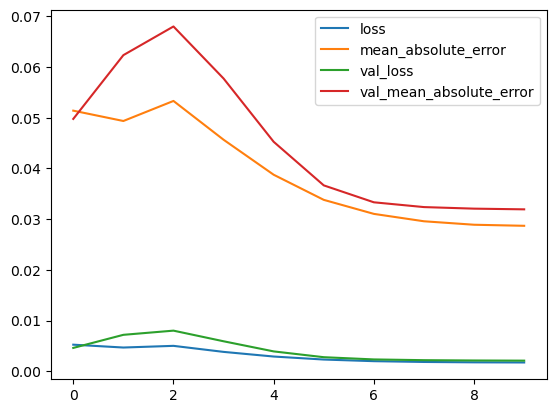

In [30]:
pd.DataFrame(history.history).plot()

In [31]:
def plot(input_data, predicted_data, output_compare, limit_right=None):
    if limit_right is not None:
        input_data = input_data[:limit_right]
        predicted_data = predicted_data[:limit_right]
        output_compare = output_compare[:limit_right]
        
    compare_y_shift = feature_sequence_length + forecasting_label_steps
    compare_y = list(range(compare_y_shift, compare_y_shift+ len(output_compare)))
    
    predicted_y_shift = feature_sequence_length + forecasting_label_steps
    predicted_y = list(range(predicted_y_shift, predicted_y_shift + len(predicted_data)))
    
    #input_data_limit = feature_sequence_length

    plt.figure(figsize=(20,6))
    plt.plot(input_data, label = "past", linestyle = 'dashed')
    plt.plot(predicted_y, predicted_data, label = "predicted")
    plt.plot(compare_y, output_compare, label = "real data", linestyle = 'dotted')
    plt.plot(feature_sequence_length, input_data[feature_sequence_length-1], "rx", label = "start prediction")
    plt.legend()
    plt.show()

In [32]:
for x, y in dataset_test.take(0):
    #print(x)
    #print(y)
    predicted_data = normalizer_wti.inverse_transform_numpy_array(model.predict(x.numpy()))
    #input_data = list(x.as_numpy_iterator())[0][0][:, 1]
    #print(x[:,0,0])
    input_data = normalizer_wti.inverse_transform_numpy_array(x[:, 0, 0].numpy())
    #print("input")
    #print(input_data)
    #output_compare = list(x.as_numpy_iterator())[0][1]
    output_compare = normalizer_wti.inverse_transform_numpy_array(y.numpy())
    #print("output")
    #print(output_compare)
    plot(input_data, predicted_data, output_compare)

In [33]:
for x, y in dataset_train.take(0):
    #print(x)
    #print(y)
    predicted_data = normalizer_wti.inverse_transform_numpy_array(model.predict(x.numpy()))
    #input_data = list(x.as_numpy_iterator())[0][0][:, 1]
    #print(x[:,0,0])
    input_data = normalizer_wti.inverse_transform_numpy_array(x[:, 0, 0].numpy())
    #print("input")
    #print(input_data)
    #output_compare = list(x.as_numpy_iterator())[0][1]
    output_compare = normalizer_wti.inverse_transform_numpy_array(y.numpy())
    #print("output")
    #print(output_compare)
    plot(input_data, predicted_data, output_compare)

In [34]:
# https://medium.com/@prajjwalchauhan94017/stock-prediction-and-forecasting-using-lstm-long-short-term-memory-9ff56625de73

In [35]:
predicted_dataset_train = model.predict(dataset_train)

160/160 [==============================] - 8s 48ms/step


In [36]:
len(predicted_dataset_train)

5119

In [37]:
len(predicted_dataset_train[:,0])

5119

In [38]:
x_train_data[:,0]

array([0.3468649 , 0.34851062, 0.34713918, ..., 0.53113174, 0.5345329 ,
       0.5340392 ], dtype=float32)

In [39]:
# inverse transforms
normalizer_wti.inverse_transform_numpy_array(x_train_data[:,0])
normalizer_wti.inverse_transform_numpy_array(predicted_dataset_train[:,0])
normalizer_wti.inverse_transform_numpy_array(x_train_targets)

array([18.899998, 18.75    , 18.600002, ..., 66.37999 , 66.630005,
       66.91    ], dtype=float32)

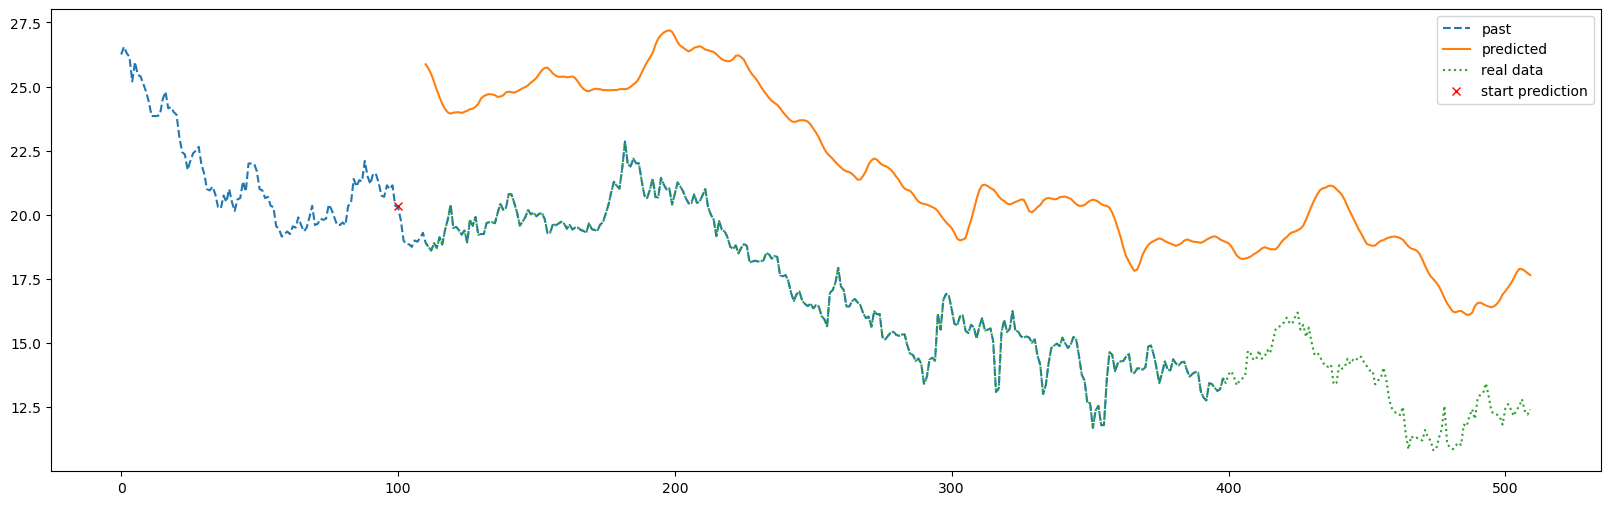

In [40]:
plot(
    normalizer_wti.inverse_transform_numpy_array(x_train_data[:,0]),
    normalizer_wti.inverse_transform_numpy_array(predicted_dataset_train[:,0]), 
    normalizer_wti.inverse_transform_numpy_array(x_train_targets), 
    limit_right=400
)

In [ ]:
predicted_dataset_test = model.predict(dataset_test)

36/36 [==============================] - 1s 40ms/step


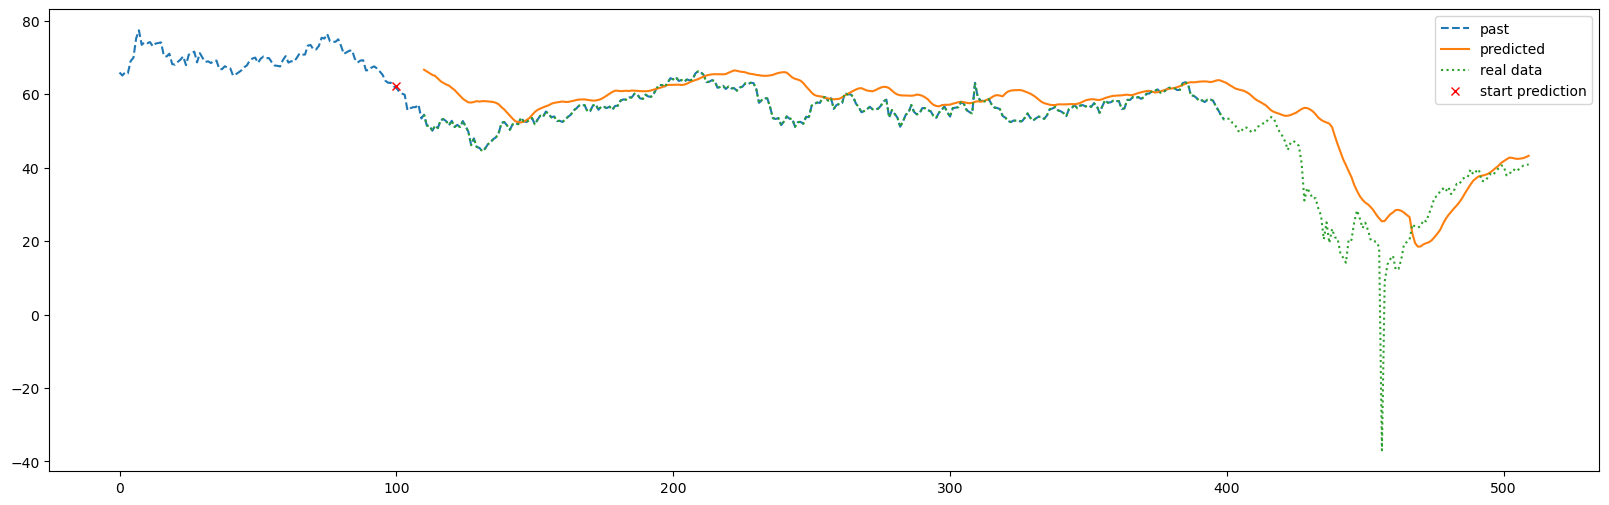

In [ ]:
plot(
    normalizer_wti.inverse_transform_numpy_array(x_test_data[:,0]),
    normalizer_wti.inverse_transform_numpy_array(predicted_dataset_test[:,0]), 
    normalizer_wti.inverse_transform_numpy_array(x_test_targets), 
    limit_right=400
)